## Modelling

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from python_files.data import GetData
from sklearn.model_selection import learning_curve
from python_files.basic_preprocessing import BasicPreprocessing
from python_files.preprocessing import Advancedprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import collections
import re
import itertools
import string
from functools import reduce
from datetime import datetime
import pickle

import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.base import TransformerMixin, BaseEstimator
from scipy import stats
from scipy.stats import pearsonr
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import FunctionTransformer
from wordcloud import WordCloud
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [8]:
data = GetData().get_data()['AllMoviesDetailsCleaned']
data.head()

,id,budget,genres,imdb_id,original_language,original_title,overview,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,belongs_to_collection,popularity
0,2,0,Drama|Crime,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,Villealfa Filmproduction Oy,Finland,21/10/1988,0,69.0,suomi,Released,NaN,Ariel,7.1,40,2,1,2,NaN,3.860491
1,3,0,Drama|Comedy,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",Villealfa Filmproduction Oy,Finland,16/10/1986,0,76.0,English,Released,NaN,Shadows in Paradise,7.0,32,1,1,3,NaN,2.292110
2,5,4000000,Crime|Comedy,tt0113101,en,Four Rooms,It's Ted the Bellhop's first night on the job....,Miramax Films,United States of America,25/12/1995,4300000,98.0,English,Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,485,2,1,1,NaN,9.026586
3,6,0,Action|Thriller|Crime,tt0107286,en,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",Universal Pictures,Japan,15/10/1993,12136938,110.0,English,Released,Don't move. Don't whisper. Don't even breathe.,Judgment Night,6.5,69,3,2,1,NaN,5.538671
4,8,42000,Documentary,tt0825671,en,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,inLoops,Austria,01/01/2006,0,80.0,English,Released,A Megacities remix.,Life in Loops (A Megacities RMX),6.4,4,1,1,5,NaN,NaN


In [9]:
df = data.copy()

In [10]:
df_cleaned = BasicPreprocessing.apply(df)
df_cleaned.head()

,id,budget,genres,original_language,original_title,overview,production_companies,production_countries,release_date,revenue,runtime,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,popularity,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
2,5,4000000,Crime|Comedy,en,Four Rooms,It's Ted the Bellhop's first night on the job....,Miramax Films,United States of America,25/12/1995,4300000,98.0,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,485,2,1,1,9.026586,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,11,11000000,Adventure|Action|Science Fiction,en,Star Wars,Princess Leia is captured and held hostage by ...,Lucasfilm,United States of America,25/05/1977,775398007,121.0,"A long time ago in a galaxy far, far away...",Star Wars,8.0,6168,2,1,1,42.149697,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,12,94000000,Animation|Family,en,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,United States of America,30/05/2003,940335536,100.0,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,7.6,5531,1,1,1,25.497794,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,13,55000000,Comedy|Drama|Romance,en,Forrest Gump,A man with a low IQ has accomplished great thi...,Paramount Pictures,United States of America,06/07/1994,677945399,142.0,"The world will never be the same, once you've ...",Forrest Gump,8.2,7204,1,1,1,48.307194,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
9,14,15000000,Drama,en,American Beauty,"Lester Burnham, a depressed suburban father in...",DreamWorks SKG,United States of America,15/09/1999,356296601,122.0,Look closer.,American Beauty,7.9,2994,2,1,1,20.726578,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


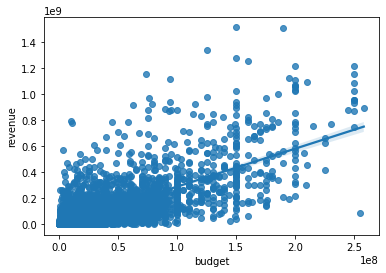

In [11]:
import seaborn as sns
sns.regplot(x='budget', y='revenue', data=df_cleaned);

In [12]:
round(df_cleaned.corr(), 2)

,id,budget,revenue,runtime,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,popularity,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
id,1.00,-0.06,-0.02,0.01,-0.14,0.02,0.04,-0.02,-0.09,0.12,-0.12,-0.03,-0.05,0.01,-0.02,-0.06,0.01,0.02,-0.03,-0.04,0.00,0.03,-0.03,-0.00,-0.05,-0.03,-0.06,0.03,-0.06,0.00,-0.03
budget,-0.06,1.00,0.73,0.14,0.05,0.58,0.24,0.12,0.09,0.29,0.21,0.27,0.37,0.19,-0.05,-0.02,-0.07,-0.20,0.22,0.25,-0.07,-0.00,-0.11,-0.05,0.00,-0.12,0.19,-0.01,0.03,0.00,-0.00
revenue,-0.02,0.73,1.00,0.14,0.18,0.76,0.13,0.04,0.07,0.41,0.36,0.16,0.32,0.20,-0.02,-0.05,-0.05,-0.18,0.21,0.21,-0.05,-0.04,-0.07,-0.03,-0.02,-0.07,0.13,-0.01,-0.02,-0.02,-0.03
runtime,0.01,0.14,0.14,1.00,0.26,0.16,0.04,0.07,0.16,0.08,-0.08,0.08,0.05,-0.21,-0.23,0.02,-0.05,0.26,-0.17,-0.04,0.08,0.24,-0.16,0.01,0.01,0.08,-0.03,-0.01,-0.01,0.15,0.07
vote_average,-0.14,0.05,0.18,0.26,1.00,0.30,0.10,0.07,0.13,0.16,0.01,-0.07,0.01,0.04,-0.12,0.05,0.03,0.21,-0.00,-0.01,-0.07,0.09,-0.12,0.03,0.04,-0.01,-0.03,-0.05,-0.02,0.08,0.05
vote_count,0.02,0.58,0.76,0.16,0.30,1.00,0.20,0.08,0.08,0.44,0.28,0.16,0.23,0.09,-0.09,0.01,-0.05,-0.12,0.08,0.15,-0.06,-0.04,-0.04,-0.05,0.01,-0.10,0.20,-0.01,0.04,-0.01,-0.00
production_companies_number,0.04,0.24,0.13,0.04,0.10,0.20,1.00,0.48,0.13,0.11,0.02,0.09,0.06,-0.02,-0.12,0.06,-0.04,0.02,-0.04,0.07,-0.08,0.02,0.02,-0.04,0.03,-0.09,0.08,-0.01,0.11,0.04,-0.02
production_countries_number,-0.02,0.12,0.04,0.07,0.07,0.08,0.48,1.00,0.18,0.06,0.04,0.07,0.07,-0.04,-0.14,0.01,-0.02,0.04,-0.03,0.05,-0.02,0.09,0.03,-0.03,0.03,-0.03,0.06,0.02,0.08,0.09,0.00
spoken_languages_number,-0.09,0.09,0.07,0.16,0.13,0.08,0.13,0.18,1.00,0.03,0.03,0.12,0.06,-0.03,-0.08,0.06,-0.00,0.03,-0.07,-0.04,-0.02,0.13,-0.04,-0.02,0.01,-0.02,-0.01,-0.01,0.10,0.15,0.01
popularity,0.12,0.29,0.41,0.08,0.16,0.44,0.11,0.06,0.03,1.00,0.14,0.08,0.13,0.08,-0.05,0.01,-0.04,-0.08,0.07,0.09,-0.05,-0.01,-0.00,-0.03,0.01,-0.06,0.07,-0.00,0.03,-0.00,-0.00


In [13]:
df_cleaned.shape

(5318, 40)

In [14]:
df_cleaned.columns

Index(['id', 'budget', 'genres', 'original_language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'tagline', 'title',
       'vote_average', 'vote_count', 'production_companies_number',
       'production_countries_number', 'spoken_languages_number', 'popularity',
       'collection', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western'],
      dtype='object')

In [15]:
df_cleaned.describe()

,id,budget,revenue,runtime,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,popularity,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
count,5318.000000,5.318000e+03,5.318000e+03,5303.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,4983.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000,5318.000000
mean,64272.157954,3.047529e+07,8.709011e+07,110.598529,6.158180,637.922151,2.853328,1.348063,1.474238,9.868112,0.218503,0.264573,0.176382,0.055096,0.343174,0.155698,0.010530,0.474615,0.098345,0.094208,0.010154,0.045130,0.101542,0.034411,0.081422,0.191425,0.111696,0.000376,0.274351,0.036856,0.015983
std,99603.990703,3.868185e+07,1.539104e+08,23.838544,1.159708,1096.118570,2.190289,0.795504,0.924045,13.656304,0.413269,0.441147,0.381181,0.228189,0.474814,0.362603,0.102085,0.499402,0.297809,0.292146,0.100265,0.207608,0.302073,0.182301,0.273507,0.393460,0.315022,0.019391,0.446229,0.188426,0.125423
min,5.000000,3.100000e+05,3.003000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8859.250000,5.000000e+06,6.805150e+06,96.000000,5.700000,58.000000,1.000000,1.000000,1.000000,5.760685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15043.000000,1.600000e+07,2.862905e+07,107.000000,6.300000,237.000000,2.000000,1.000000,1.000000,8.552967,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,68410.250000,4.000000e+07,9.789858e+07,121.000000,6.900000,707.750000,4.000000,1.000000,2.000000,11.825021,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,468938.000000,2.580000e+08,1.513529e+09,338.000000,10.000000,12811.000000,26.000000,12.000000,9.000000,547.488298,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
Q1 = df_cleaned['revenue'].quantile(0.25)

Q3 = df_cleaned['revenue'].quantile(0.75)

IQR = Q3 - Q1

print(f'{IQR:,}')

91,093,435.0


In [17]:
print(df_cleaned['revenue'].skew())

3.6311952990163476


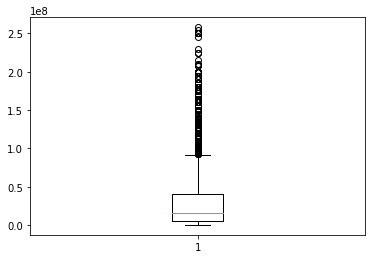

In [18]:
plt.boxplot(df_cleaned['budget'])

plt.show()

In [19]:
df_cleaned['budget'].sort_values(ascending = False)

439       258000000
39838     255000000
83640     250000000
81324     250000000
33314     250000000
            ...    
2044         325000
17564        322000
122576       318000
38203        312000
112720       310000
Name: budget, Length: 5318, dtype: int64

In [21]:
X = df_cleaned.drop(columns = ['revenue'])
y = df_cleaned['revenue']

### Splitting data into train and test sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

# Print split result
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4254, 39)
(1064, 39)
(4254,)
(1064,)


In [23]:
X_train_processed, list_top_30 = Advancedprocessing.process(X_train)
X_test_processed, _ = Advancedprocessing.process(X_test, train_set=False)

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2224: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[header_name] = dataset[col].apply(lambda x: 1 if item in x else 0)
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:57: UserWarning: Parsing '17/03/2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df_copy['release_date'] = pd.to_datetime(df_copy['release_date'], infer_datetime_format=True)
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:57: UserWarning: Parsing '23/03/2007' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df_copy['release_date'] = pd.to_datetime(df_copy['release_date'], infer_datetime_format=True)
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:57: UserWarning: Parsing '16/04/1999' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df_copy['release_date'] = pd.to_datetime(df_copy['release_date'], infer_datetime_format=True)
/home/sourav/code/Urus1201/data-movie-re

In [24]:
# Create validation sets
X_train_processed_part, X_val, y_train_part, y_val = train_test_split(X_train_processed, 
                                                              y_train, 
                                                              test_size = 0.2,
                                                              random_state = 42)

# Print split result
print(X_train_processed_part.shape)
print(X_val.shape)
print(y_train_part.shape)
print(y_val.shape)

(3403, 148)
(851, 148)
(3403,)
(851,)


In [25]:
# transform the y test and train to log scale
y_train_part_log = y_train_part.apply(lambda x: np.log(x + 1))
y_val_log = y_val.apply(lambda x: np.log(x + 1))
y_test_log = y_test.apply(lambda x: np.log(x + 1))

In [26]:
# Min max scaler for budget (log)
# minmax_scaler = MinMaxScaler()

# X_train_processed_part['budget'] = minmax_scaler.fit_transform(X_train_processed_part[['budget']]
                                                               
# X_val['budget'] = minmax_scaler.transform(X_val[['budget']])
                                          
# X_test_processed['budget'] = minmax_scaler.transform(X_test_processed[['budget']])

In [27]:
# RobustScaler for rest of the numerical features
rbst_scaler = RobustScaler()
features = ['runtime', 'release_age', 'production_companies_number', 'production_countries_number', 'popularity', #'vote_average', 'vote_count',
            'actor_number', 'director_number', 'producer_number', 'release_age', 'budget_year_ratio'] #'spoken_languages_number'

X_train_processed_part[features] = rbst_scaler.fit_transform(X_train_processed_part[features])

X_val[features] = rbst_scaler.transform(X_val[features])

X_test_processed[features] = rbst_scaler.transform(X_test_processed[features])

In [28]:
X_train_processed_part.describe()

,runtime,vote_average,vote_count,production_companies_number,production_countries_number,popularity,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,actor_number,director_number,producer_number,week_sin,week_cos,release_age,budget_year_ratio,Steven Spielberg_name,Ridley Scott_name,Clint Eastwood_name,Woody Allen_name,Brian De Palma_name,Martin Scorsese_name,Robert Zemeckis_name,Tim Burton_name,Steven Soderbergh_name,Ron Howard_name,Alfred Hitchcock_name,Joel Schumacher_name,Renny Harlin_name,Oliver Stone_name,Robert Rodriguez_name,Tony Scott_name,Barry Levinson_name,Richard Linklater_name,Spike Lee_name,Walter Hill_name,Rob Reiner_name,Francis Ford Coppola_name,Bobby Farrelly_name,Richard Donner_name,Billy Wilder_name,Michael Mann_name,Barry Sonnenfeld_name,Wolfgang Petersen_name,F. Gary Gray_name,Peter Hyams_name,Brian Grazer_name,Jerry Bruckheimer_name,Joel Silver_name,Tim Bevan_name,Scott Rudin_name,Neal H. Moritz_name,John Davis_name,Arnon Milchan_name,Steve Golin_name,Roger Birnbaum_name,Michael Bay_name,Gale Anne Hurd_name,Lawrence Gordon_name,Kevin Feige_name,Albert R. Broccoli_name,Tom Rosenberg_name,Charles Roven_name,John Hughes_name,Mark Johnson_name,Luc Besson_name,Danny DeVito_name,Robert De Niro_name,James G. Robinson_name,Ashok Amritraj_name,Universal Pictures_name,Paramount Pictures_name,Twentieth Century Fox Film Corporation_name,Columbia Pictures_name,New Line Cinema_name,Walt Disney Pictures_name,Warner Bros._name,Metro-Goldwyn-Mayer (MGM)_name,Miramax Films_name,United Artists_name,Columbia Pictures Corporation_name,DreamWorks SKG_name,Village Roadshow Pictures_name,TriStar Pictures_name,Fox Searchlight Pictures_name,Summit Entertainment_name,Touchstone Pictures_name,Imagine Entertainment_name,Regency Enterprises_name,Orion Pictures_name,Lions Gate Films_name,Lionsgate_name,Hollywood Pictures_name,The Weinstein Company_name,BBC Films_name,Lakeshore Entertainment_name,Dimension Films_name,Lucasfilm_name,Fox 2000 Pictures_name,StudioCanal_name,United States of America_name,United Kingdom_name,India_name,France_name,Germany_name,Canada_name,Australia_name,Russia_name,Japan_name,Italy_name,China_name,Spain_name,Ireland_name,Hong Kong_name,South Korea_name,Mexico_name,Belgium_name,New Zealand_name,Czech Republic_name,Denmark_name,Netherlands_name,Switzerland_name,Singapore_name,Israel_name,Brazil_name,Thailand_name,United Arab Emirates_name,Norway_name,Sweden_name,Finland_name
count,3392.000000,3403.000000,3403.000000,3403.000000,3403.000000,3.198000e+03,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.00000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.

In [29]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy= 'mean')

imputer.fit(X_train_processed_part[['popularity', 'runtime']])

X_train_processed_part[['popularity', 'runtime']] = imputer.transform(X_train_processed_part[['popularity', 'runtime']])
X_val[['popularity', 'runtime']] = imputer.transform(X_val[['popularity', 'runtime']])
X_test_processed[['popularity', 'runtime']] = imputer.transform(X_test_processed[['popularity', 'runtime']])

In [30]:
X_train_processed_part.describe()

,runtime,vote_average,vote_count,production_companies_number,production_countries_number,popularity,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,actor_number,director_number,producer_number,week_sin,week_cos,release_age,budget_year_ratio,Steven Spielberg_name,Ridley Scott_name,Clint Eastwood_name,Woody Allen_name,Brian De Palma_name,Martin Scorsese_name,Robert Zemeckis_name,Tim Burton_name,Steven Soderbergh_name,Ron Howard_name,Alfred Hitchcock_name,Joel Schumacher_name,Renny Harlin_name,Oliver Stone_name,Robert Rodriguez_name,Tony Scott_name,Barry Levinson_name,Richard Linklater_name,Spike Lee_name,Walter Hill_name,Rob Reiner_name,Francis Ford Coppola_name,Bobby Farrelly_name,Richard Donner_name,Billy Wilder_name,Michael Mann_name,Barry Sonnenfeld_name,Wolfgang Petersen_name,F. Gary Gray_name,Peter Hyams_name,Brian Grazer_name,Jerry Bruckheimer_name,Joel Silver_name,Tim Bevan_name,Scott Rudin_name,Neal H. Moritz_name,John Davis_name,Arnon Milchan_name,Steve Golin_name,Roger Birnbaum_name,Michael Bay_name,Gale Anne Hurd_name,Lawrence Gordon_name,Kevin Feige_name,Albert R. Broccoli_name,Tom Rosenberg_name,Charles Roven_name,John Hughes_name,Mark Johnson_name,Luc Besson_name,Danny DeVito_name,Robert De Niro_name,James G. Robinson_name,Ashok Amritraj_name,Universal Pictures_name,Paramount Pictures_name,Twentieth Century Fox Film Corporation_name,Columbia Pictures_name,New Line Cinema_name,Walt Disney Pictures_name,Warner Bros._name,Metro-Goldwyn-Mayer (MGM)_name,Miramax Films_name,United Artists_name,Columbia Pictures Corporation_name,DreamWorks SKG_name,Village Roadshow Pictures_name,TriStar Pictures_name,Fox Searchlight Pictures_name,Summit Entertainment_name,Touchstone Pictures_name,Imagine Entertainment_name,Regency Enterprises_name,Orion Pictures_name,Lions Gate Films_name,Lionsgate_name,Hollywood Pictures_name,The Weinstein Company_name,BBC Films_name,Lakeshore Entertainment_name,Dimension Films_name,Lucasfilm_name,Fox 2000 Pictures_name,StudioCanal_name,United States of America_name,United Kingdom_name,India_name,France_name,Germany_name,Canada_name,Australia_name,Russia_name,Japan_name,Italy_name,China_name,Spain_name,Ireland_name,Hong Kong_name,South Korea_name,Mexico_name,Belgium_name,New Zealand_name,Czech Republic_name,Denmark_name,Netherlands_name,Switzerland_name,Singapore_name,Israel_name,Brazil_name,Thailand_name,United Arab Emirates_name,Norway_name,Sweden_name,Finland_name
count,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.00000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.000000,3403.0

In [31]:
X_train_processed_part.head()

,runtime,vote_average,vote_count,production_companies_number,production_countries_number,popularity,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,actor_number,director_number,producer_number,week_sin,week_cos,release_age,budget_year_ratio,Steven Spielberg_name,Ridley Scott_name,Clint Eastwood_name,Woody Allen_name,Brian De Palma_name,Martin Scorsese_name,Robert Zemeckis_name,Tim Burton_name,Steven Soderbergh_name,Ron Howard_name,Alfred Hitchcock_name,Joel Schumacher_name,Renny Harlin_name,Oliver Stone_name,Robert Rodriguez_name,Tony Scott_name,Barry Levinson_name,Richard Linklater_name,Spike Lee_name,Walter Hill_name,Rob Reiner_name,Francis Ford Coppola_name,Bobby Farrelly_name,Richard Donner_name,Billy Wilder_name,Michael Mann_name,Barry Sonnenfeld_name,Wolfgang Petersen_name,F. Gary Gray_name,Peter Hyams_name,Brian Grazer_name,Jerry Bruckheimer_name,Joel Silver_name,Tim Bevan_name,Scott Rudin_name,Neal H. Moritz_name,John Davis_name,Arnon Milchan_name,Steve Golin_name,Roger Birnbaum_name,Michael Bay_name,Gale Anne Hurd_name,Lawrence Gordon_name,Kevin Feige_name,Albert R. Broccoli_name,Tom Rosenberg_name,Charles Roven_name,John Hughes_name,Mark Johnson_name,Luc Besson_name,Danny DeVito_name,Robert De Niro_name,James G. Robinson_name,Ashok Amritraj_name,Universal Pictures_name,Paramount Pictures_name,Twentieth Century Fox Film Corporation_name,Columbia Pictures_name,New Line Cinema_name,Walt Disney Pictures_name,Warner Bros._name,Metro-Goldwyn-Mayer (MGM)_name,Miramax Films_name,United Artists_name,Columbia Pictures Corporation_name,DreamWorks SKG_name,Village Roadshow Pictures_name,TriStar Pictures_name,Fox Searchlight Pictures_name,Summit Entertainment_name,Touchstone Pictures_name,Imagine Entertainment_name,Regency Enterprises_name,Orion Pictures_name,Lions Gate Films_name,Lionsgate_name,Hollywood Pictures_name,The Weinstein Company_name,BBC Films_name,Lakeshore Entertainment_name,Dimension Films_name,Lucasfilm_name,Fox 2000 Pictures_name,StudioCanal_name,United States of America_name,United Kingdom_name,India_name,France_name,Germany_name,Canada_name,Australia_name,Russia_name,Japan_name,Italy_name,China_name,Spain_name,Ireland_name,Hong Kong_name,South Korea_name,Mexico_name,Belgium_name,New Zealand_name,Czech Republic_name,Denmark_name,Netherlands_name,Switzerland_name,Singapore_name,Israel_name,Brazil_name,Thailand_name,United Arab Emirates_name,Norway_name,Sweden_name,Finland_name
4184,-0.56,5.5,449,0.333333,0.0,-0.320877,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2.692308,0.0,0.5,0.568065,0.822984,0.1250,1.261610,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1123,-0.88,5.8,852,0.333333,1.0,-0.023858,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.076923,0.0,-0.5,0.464723,0.885456,0.3125,3.366592,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3061,0.88,7.5,171,-0.333333,0.0,-0.557076,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,-0.692308,0.0,-1.0,0.354605,0.935016,-0.2500,-0.319005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2609,1.20,6.3,1091,0.000000,0.0,0.454780,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.538462,0.0,0.0,0.354605,0.935016,0.4375,2.274012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Modelling

### Baseline

In [32]:
# Add scoring function
scorer = make_scorer(mean_squared_error)

In [33]:
model = LinearRegression()

In [34]:
baseline_mse_score = cross_val_score( model, X_train_processed_part, y_train_part_log, cv = 10, scoring= make_scorer(mean_squared_error)).mean()

In [35]:
np.sqrt(baseline_mse_score)

215218540.51360556

In [36]:
model.fit(X_train_processed_part, y_train_part_log)

LinearRegression()

In [61]:
# Create dataframe with predicted values
comp_df = pd.DataFrame({"actual": np.expm1(y_test_log), "predictions": np.expm1(model.predict(X_test_processed))})

# Add actual values to dataframe
# comp_df['actual'] = np.expm1(y_cross)

# Add column with difference of the two values
comp_df['difference'] = comp_df['predictions'] - comp_df['actual']

# Add column that shows the percent difference between predicted and actual value
comp_df['percent_diff'] = abs(abs(comp_df['predictions'] / (comp_df['actual'])) - 1) * 100

# Add column that designates a difference of less than 20% as 'okay' and 20% or more as 'bad'
comp_df['okay'] = comp_df['percent_diff'].apply(lambda x: 'okay' if x < 20 else 'bad')
comp_df

,actual,predictions,difference,percent_diff,okay
126595,100654149.0,1.957440e+07,-8.107975e+07,80.552814,bad
189150,61619773.0,8.858291e+06,-5.276148e+07,85.624273,bad
34608,2500000.0,5.913427e+05,-1.908657e+06,76.346292,bad
4978,204999686.0,6.511699e+07,-1.398827e+08,68.235567,bad
885,95608995.0,9.604051e+07,4.315112e+05,0.451329,okay
...,...,...,...,...,...
35136,766075.0,3.782917e+06,3.016842e+06,393.804995,bad
7341,55089.0,4.362914e+06,4.307825e+06,7819.754996,bad
8496,7830611.0,5.041970e+06,-2.788641e+06,35.612044,bad
199,136766062.0,1.098965e+08,-2.686954e+07,19.646350,okay


<AxesSubplot:xlabel='difference', ylabel='Count'>

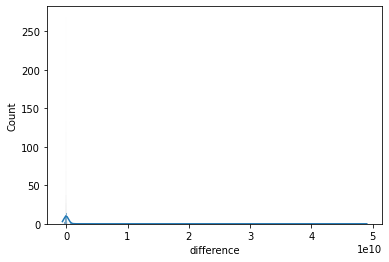

In [63]:
sns.histplot( comp_df['difference'], kde= True)

In [41]:
# Which movies had a difference of less than 20% in the predicted vs. the actual revenue value 
comp_df[comp_df['okay'] == 'okay'].sort_values('percent_diff').reset_index()

,index,actual,predictions,difference,percent_diff,okay
0,154986,3700000.0,3.701095e+06,1.095349e+03,0.029604,okay
1,10875,37402877.0,3.736913e+07,-3.374705e+04,0.090226,okay
2,23965,224920315.0,2.246482e+08,-2.721443e+05,0.120996,okay
3,20199,18409891.0,1.834342e+07,-6.647168e+04,0.361065,okay
4,885,95608995.0,9.604051e+07,4.315112e+05,0.451329,okay
...,...,...,...,...,...,...
123,3843,36733909.0,2.956478e+07,-7.169132e+06,19.516386,okay
124,199,136766062.0,1.098965e+08,-2.686954e+07,19.646350,okay
125,12489,5000000.0,4.011129e+06,-9.888710e+05,19.777420,okay
126,951,289847354.0,2.324806e+08,-5.736670e+07,19.792040,okay


### XGBoost

In [42]:
# Create DMatrix for train set, cross-validation set and test set (which is X_cross)
train_set = xgb.DMatrix(X_train_processed_part, label=y_train_part_log)
test_set = xgb.DMatrix(X_val, label=y_val_log)
cross_set = xgb.DMatrix(X_test_processed, label=y_test_log)

# Define the initial parameters to use (default values)
parameters_xgb = {'learning_rate': 0.3, 
                  'max_depth': 6, 
                  'alpha': 0, 
                  'subsample': 1,
                  'min_child_weight': 1, 
                  'colsample_bytree': 1} 

# Define the variations of each parameter to be checked
learning_rate = [0.3, 0.1, 0.01]
max_depth = [6, 8, 10]
alpha = [0, 5, 10]
subsample = [0.5, 0.7, 1]
min_child_weight = [1, 3, 6]
colsample_bytree = [0.5, 0.7, 1]

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [43]:
# This code was adapted from https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
def grid_search_xgb(param1, param2, param1_vals, param2_vals):
    '''
    Function to simulate gridsearch on XGBoost model testing two different values at a time
    Args: param1 = string; name of first parameter
          param2 = string; name of second parameter
          param1_vals = list; values to be checked
          param2_vals = list; values to be checked
    Returns: None
    '''
    
    min_rmse = float("Inf")
    best_parameters = None
    overall_best = collections.defaultdict()

    for val1 in param1_vals:
        for val2 in param2_vals:
            parameters_xgb[param1] = val1
            parameters_xgb[param2] = val2
            cv_results_xgb = xgb.cv(params = parameters_xgb,
                                dtrain=train_set,
                                num_boost_round=1000,
                                seed=42,
                                nfold=5,
                                metrics={'rmse'},
                                early_stopping_rounds=15)

            best_rmse = cv_results_xgb['test-rmse-mean'].min() 
            boost_rounds = cv_results_xgb['test-rmse-mean'].idxmin()
            print('{}: {}, {}: {}'.format(param1, val1, param2, val2))
            print('\tRMSE {} for {} rounds'.format(best_rmse, boost_rounds))
            
            if best_rmse < min_rmse:
                min_rmse = best_rmse
                best_parameters = (val1, val2)
        
        print('Best params: {} of {}, {} of {}, RMSE: {}'.format(param1, 
                                                                 best_parameters[0], 
                                                                 param2, 
                                                                 best_parameters[1], 
                                                                 min_rmse))

In [44]:
# Gridsearch through learning_rate and max_depth values for XGBoost model
grid_search_xgb('learning_rate', 'max_depth', learning_rate, max_depth)

learning_rate: 0.3, max_depth: 6
	RMSE 1.2862786 for 21 rounds
learning_rate: 0.3, max_depth: 8
	RMSE 1.3123466000000001 for 19 rounds
learning_rate: 0.3, max_depth: 10
	RMSE 1.3226532 for 33 rounds
Best params: learning_rate of 0.3, max_depth of 6, RMSE: 1.2862786
learning_rate: 0.1, max_depth: 6
	RMSE 1.2499862 for 104 rounds
learning_rate: 0.1, max_depth: 8
	RMSE 1.2574896 for 88 rounds
learning_rate: 0.1, max_depth: 10
	RMSE 1.2683808 for 91 rounds
Best params: learning_rate of 0.1, max_depth of 6, RMSE: 1.2499862
learning_rate: 0.01, max_depth: 6
	RMSE 1.2439404 for 850 rounds
learning_rate: 0.01, max_depth: 8
	RMSE 1.2504088 for 762 rounds
learning_rate: 0.01, max_depth: 10
	RMSE 1.2592186 for 925 rounds
Best params: learning_rate of 0.01, max_depth of 6, RMSE: 1.2439404


😎**Inference:** _Based on the above, a learning_rate of 0.01 and a max_depth of 6 have the lowest RMSE. I will update the parameters dict._

In [45]:
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.01
parameters_xgb['max_depth'] = 6

# Gridsearch through alpha and subsample values for XGBoost model
grid_search_xgb('alpha', 'subsample', alpha, subsample)

alpha: 0, subsample: 0.5
	RMSE 1.2263362 for 762 rounds
alpha: 0, subsample: 0.7
	RMSE 1.2276434 for 877 rounds
alpha: 0, subsample: 1
	RMSE 1.2439404 for 850 rounds
Best params: alpha of 0, subsample of 0.5, RMSE: 1.2263362
alpha: 5, subsample: 0.5
	RMSE 1.2354464 for 839 rounds
alpha: 5, subsample: 0.7
	RMSE 1.23055 for 981 rounds
alpha: 5, subsample: 1
	RMSE 1.2390173999999998 for 960 rounds
Best params: alpha of 0, subsample of 0.5, RMSE: 1.2263362
alpha: 10, subsample: 0.5
	RMSE 1.2421152 for 952 rounds
alpha: 10, subsample: 0.7
	RMSE 1.239458 for 998 rounds
alpha: 10, subsample: 1
	RMSE 1.2473064 for 859 rounds
Best params: alpha of 0, subsample of 0.5, RMSE: 1.2263362


😎**Inference:** _Based on the above, an alpha value of 0 and a subsample value of 0.7 have the lowest RMSE. I will update the parameters dict._

In [46]:
# Update alpha and lambda
parameters_xgb['alpha'] = 0
parameters_xgb['subsample'] = 0.5
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.01
parameters_xgb['max_depth'] = 6

# Gridsearch through min_child_weight and colsample_bytree values for XGBoost model
grid_search_xgb('min_child_weight', 'colsample_bytree', min_child_weight, colsample_bytree)

min_child_weight: 1, colsample_bytree: 0.5
	RMSE 1.2241656 for 962 rounds
min_child_weight: 1, colsample_bytree: 0.7
	RMSE 1.2218566000000002 for 923 rounds
min_child_weight: 1, colsample_bytree: 1
	RMSE 1.2263362 for 762 rounds
Best params: min_child_weight of 1, colsample_bytree of 0.7, RMSE: 1.2218566000000002
min_child_weight: 3, colsample_bytree: 0.5
	RMSE 1.2225718 for 823 rounds
min_child_weight: 3, colsample_bytree: 0.7
	RMSE 1.2196658 for 834 rounds
min_child_weight: 3, colsample_bytree: 1
	RMSE 1.2171562 for 767 rounds
Best params: min_child_weight of 3, colsample_bytree of 1, RMSE: 1.2171562
min_child_weight: 6, colsample_bytree: 0.5
	RMSE 1.2220334 for 832 rounds
min_child_weight: 6, colsample_bytree: 0.7
	RMSE 1.2145538000000002 for 790 rounds
min_child_weight: 6, colsample_bytree: 1
	RMSE 1.2146432 for 768 rounds
Best params: min_child_weight of 6, colsample_bytree of 0.7, RMSE: 1.2145538000000002


😎**Inference:** _Based on the above, a min_child_weight value of 3 and a colsample_bytree value of 0.7 have the lowest RMSE. I will update the parameters dict._

With those updated parameters, I will predict the revenue values for the X_cross dataset.


In [47]:
# Update alpha and lambda
parameters_xgb['alpha'] = 5
parameters_xgb['subsample'] = 0.7
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.01
parameters_xgb['max_depth'] = 6
# Update min_child_weight and colsample_bytree
parameters_xgb['min_child_weight'] = 6
parameters_xgb['colsample_bytree'] = 1

In [48]:
# Predicting values
test_set = xgb.DMatrix(X_val, label=y_val_log)
cross_set = xgb.DMatrix(X_test_processed, label=y_test_log)

clf_xgb = xgb.train(params = parameters_xgb,
                  dtrain = train_set,
                  num_boost_round=1000,
                  evals=[(test_set, "Test")],
                  early_stopping_rounds=100)

y_pred_xgb = clf_xgb.predict(cross_set)

[0]	Test-rmse:16.42298
[1]	Test-rmse:16.26143
[2]	Test-rmse:16.10168
[3]	Test-rmse:15.94322
[4]	Test-rmse:15.78689
[5]	Test-rmse:15.63215
[6]	Test-rmse:15.47867
[7]	Test-rmse:15.32648
[8]	Test-rmse:15.17571
[9]	Test-rmse:15.02679
[10]	Test-rmse:14.87900
[11]	Test-rmse:14.73297
[12]	Test-rmse:14.58829
[13]	Test-rmse:14.44514
[14]	Test-rmse:14.30323
[15]	Test-rmse:14.16372
[16]	Test-rmse:14.02497
[17]	Test-rmse:13.88751
[18]	Test-rmse:13.75135
[19]	Test-rmse:13.61610
[20]	Test-rmse:13.48208
[21]	Test-rmse:13.35004
[22]	Test-rmse:13.21867
[23]	Test-rmse:13.08962
[24]	Test-rmse:12.96171
[25]	Test-rmse:12.83502
[26]	Test-rmse:12.70958
[27]	Test-rmse:12.58572
[28]	Test-rmse:12.46255
[29]	Test-rmse:12.34022
[30]	Test-rmse:12.21926
[31]	Test-rmse:12.09941
[32]	Test-rmse:11.98125
[33]	Test-rmse:11.86393
[34]	Test-rmse:11.74828
[35]	Test-rmse:11.63405
[36]	Test-rmse:11.51983
[37]	Test-rmse:11.40741
[38]	Test-rmse:11.29613
[39]	Test-rmse:11.18659
[40]	Test-rmse:11.07748
[41]	Test-rmse:10.96979
[4

[344]	Test-rmse:1.37502
[345]	Test-rmse:1.37260
[346]	Test-rmse:1.37027
[347]	Test-rmse:1.36797
[348]	Test-rmse:1.36558
[349]	Test-rmse:1.36309
[350]	Test-rmse:1.36067
[351]	Test-rmse:1.35853
[352]	Test-rmse:1.35613
[353]	Test-rmse:1.35412
[354]	Test-rmse:1.35171
[355]	Test-rmse:1.34951
[356]	Test-rmse:1.34732
[357]	Test-rmse:1.34503
[358]	Test-rmse:1.34281
[359]	Test-rmse:1.34045
[360]	Test-rmse:1.33855
[361]	Test-rmse:1.33628
[362]	Test-rmse:1.33466
[363]	Test-rmse:1.33286
[364]	Test-rmse:1.33072
[365]	Test-rmse:1.32911
[366]	Test-rmse:1.32745
[367]	Test-rmse:1.32580
[368]	Test-rmse:1.32403
[369]	Test-rmse:1.32238
[370]	Test-rmse:1.32061
[371]	Test-rmse:1.31858
[372]	Test-rmse:1.31719
[373]	Test-rmse:1.31554
[374]	Test-rmse:1.31394
[375]	Test-rmse:1.31225
[376]	Test-rmse:1.31060
[377]	Test-rmse:1.30909
[378]	Test-rmse:1.30743
[379]	Test-rmse:1.30590
[380]	Test-rmse:1.30445
[381]	Test-rmse:1.30316
[382]	Test-rmse:1.30183
[383]	Test-rmse:1.30042
[384]	Test-rmse:1.29907
[385]	Test-rmse:

[686]	Test-rmse:1.19898
[687]	Test-rmse:1.19893
[688]	Test-rmse:1.19896
[689]	Test-rmse:1.19883
[690]	Test-rmse:1.19870
[691]	Test-rmse:1.19867
[692]	Test-rmse:1.19867
[693]	Test-rmse:1.19858
[694]	Test-rmse:1.19850
[695]	Test-rmse:1.19838
[696]	Test-rmse:1.19826
[697]	Test-rmse:1.19812
[698]	Test-rmse:1.19798
[699]	Test-rmse:1.19794
[700]	Test-rmse:1.19784
[701]	Test-rmse:1.19761
[702]	Test-rmse:1.19766
[703]	Test-rmse:1.19757
[704]	Test-rmse:1.19776
[705]	Test-rmse:1.19783
[706]	Test-rmse:1.19781
[707]	Test-rmse:1.19784
[708]	Test-rmse:1.19773
[709]	Test-rmse:1.19765
[710]	Test-rmse:1.19760
[711]	Test-rmse:1.19752
[712]	Test-rmse:1.19747
[713]	Test-rmse:1.19749
[714]	Test-rmse:1.19742
[715]	Test-rmse:1.19723
[716]	Test-rmse:1.19727
[717]	Test-rmse:1.19731
[718]	Test-rmse:1.19713
[719]	Test-rmse:1.19704
[720]	Test-rmse:1.19702
[721]	Test-rmse:1.19693
[722]	Test-rmse:1.19703
[723]	Test-rmse:1.19700
[724]	Test-rmse:1.19697
[725]	Test-rmse:1.19692
[726]	Test-rmse:1.19680
[727]	Test-rmse:

In [49]:
import math
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_error
# Regression metrics
mse = mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_xgb))
rmse = math.sqrt(mse)
mae = mean_absolute_error(np.expm1(y_test_log), np.expm1(y_pred_xgb))
rsquared = r2_score(np.expm1(y_test_log), np.expm1(y_pred_xgb))
# max_error = max_error(np.expm1(y_test_log), np.expm1(y_pred_xgb))
print('MSE =', round(mse, 2))
print('RMSE =', round(rmse, 2))
print('MAE =', round(mae, 2))
print('R2 =', round(rsquared, 2))
# print('Max Error =', round(max_error, 2))

MSE = 6033289258358794.0
RMSE = 77674250.94
MAE = 36684157.99
R2 = 0.73


In [50]:
# Set training size
train_sizes = [250,500,750,1000,1250,1500,1750,2000,2250,2500]

# Get train scores(R2), train sizes and validation scores using 'Learning curve'
train_sizes, train_scores, test_scores = learning_curve(estimator=XGBRegressor(learning_rate=0.1, n_estimators=3460,
                                                                                max_depth=6, min_child_weight=6,
                                                                                subsample=1,
                                                                                colsample_bytree=1,
                                                                                nthread=-1, alpha = 10), 
                                                        X=X_train_processed_part, 
                                                        y=y_train_part_log, 
                                                        train_sizes=train_sizes, 
                                                        cv=5)

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib

In [51]:
# Take the mean of corss-validated train scores and test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis = 1)

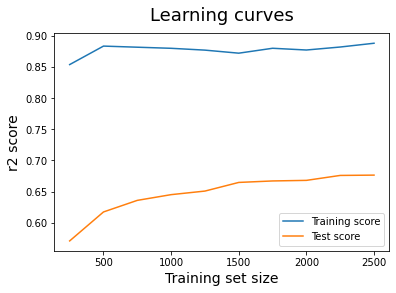

In [52]:
# Plot scores
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

In [53]:
# Saving the best XGBoost model
pickle.dump(clf_xgb, open('xgboost.sav', 'wb'))

## Evaluation

#### Root Mean Squared Error

In [54]:
# Print different metrics to evaluate XGBoost model
print('Root mean squared error for XGBoost algorithm is: ', np.sqrt(mean_squared_error(y_test_log, y_pred_xgb)))

# Inverse transform the scaled revenue data from XGB model
absolute_y_cross = np.expm1(y_test_log)
absolute_y_pred = np.expm1(y_pred_xgb.reshape(-1,1))
print('Absolute root mean squared error: ', np.sqrt(mean_squared_error(absolute_y_cross, absolute_y_pred)))

Root mean squared error for XGBoost algorithm is:  1.243540571188096
Absolute root mean squared error:  77674250.93529254


#### Checking the absolute values that were predicted vs. the actual revenue figures

In [64]:
# Create dataframe with predicted values
comp_df = pd.DataFrame({"actual": np.expm1(y_test_log), "predictions": np.expm1(clf_xgb.predict(cross_set))})

# Add actual values to dataframe
# comp_df['actual'] = np.expm1(y_cross)

# Add column with difference of the two values
comp_df['difference'] = comp_df['predictions'] - comp_df['actual']

# Add column that shows the percent difference between predicted and actual value
comp_df['percent_diff'] = abs(abs(comp_df['predictions'] / (comp_df['actual'])) - 1) * 100

# Add column that designates a difference of less than 20% as 'okay' and 20% or more as 'bad'
comp_df['okay'] = comp_df['percent_diff'].apply(lambda x: 'okay' if x < 20 else 'bad')
comp_df

,actual,predictions,difference,percent_diff,okay
126595,100654149.0,5.302570e+07,-4.762845e+07,47.318909,bad
189150,61619773.0,1.829505e+07,-4.332472e+07,70.309771,bad
34608,2500000.0,2.151929e+06,-3.480707e+05,13.922830,okay
4978,204999686.0,1.497058e+08,-5.529389e+07,26.972673,bad
885,95608995.0,6.565383e+07,-2.995516e+07,31.330905,bad
...,...,...,...,...,...
35136,766075.0,2.081251e+06,1.315176e+06,171.677137,bad
7341,55089.0,1.518089e+06,1.463000e+06,2655.702590,bad
8496,7830611.0,2.596859e+06,-5.233752e+06,66.837083,bad
199,136766062.0,1.740640e+08,3.729794e+07,27.271340,bad


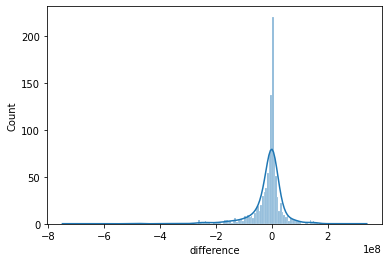

In [65]:
# visual check
sns.histplot(comp_df['difference'], kde=True, edgecolor='w');

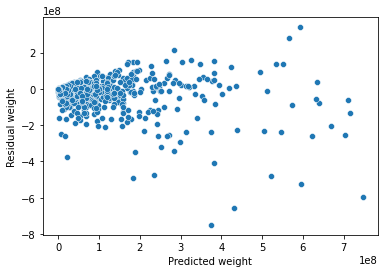

In [66]:
# Check with Residuals vs. Fitted scatterplot
sns.scatterplot(x=comp_df['predictions'], y=comp_df['difference'])
plt.xlabel('Predicted weight')
plt.ylabel('Residual weight');

In [57]:
# Which movies had a difference of less than 20% in the predicted vs. the actual revenue value 
comp_df[comp_df['okay'] == 'okay'].sort_values('percent_diff').reset_index()


,index,actual,predictions,difference,percent_diff,okay
0,1994,94679598.0,9.493399e+07,2.543940e+05,0.268689,okay
1,10097,91636986.0,9.116384e+07,-4.731460e+05,0.516326,okay
2,4950,21930418.0,2.181685e+07,-1.135660e+05,0.517847,okay
3,150995,98837872.0,9.942870e+07,5.908240e+05,0.597771,okay
4,5220,76932943.0,7.749144e+07,5.584970e+05,0.725953,okay
...,...,...,...,...,...,...
208,176,78371200.0,9.356616e+07,1.519496e+07,19.388449,okay
209,8529,5410749.0,6.465392e+06,1.054644e+06,19.491636,okay
210,146258,11672363.0,9.395883e+06,-2.276480e+06,19.503163,okay
211,88554,700000.0,5.619914e+05,-1.380086e+05,19.715518,okay


In [45]:
y_test_log.shape

(1066,)

#### Overfitting

In [70]:
# Checking for overfitting

# XGB
y_pred_train_xgb = clf_xgb.predict(xgb.DMatrix(X_train_processed_part, label=y_train_part_log))
print('Overfitting XGBoost:', np.sqrt(mean_squared_error(np.expm1(y_pred_train_xgb), np.expm1(y_train_part_log))), 'vs.', \
                              np.sqrt(mean_squared_error(np.expm1(y_pred_xgb), np.expm1(y_test_log))))

Overfitting XGBoost: 66362847.93380159 vs. 77674250.93529254


/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


### Feature Importance

**_XGBoost_**

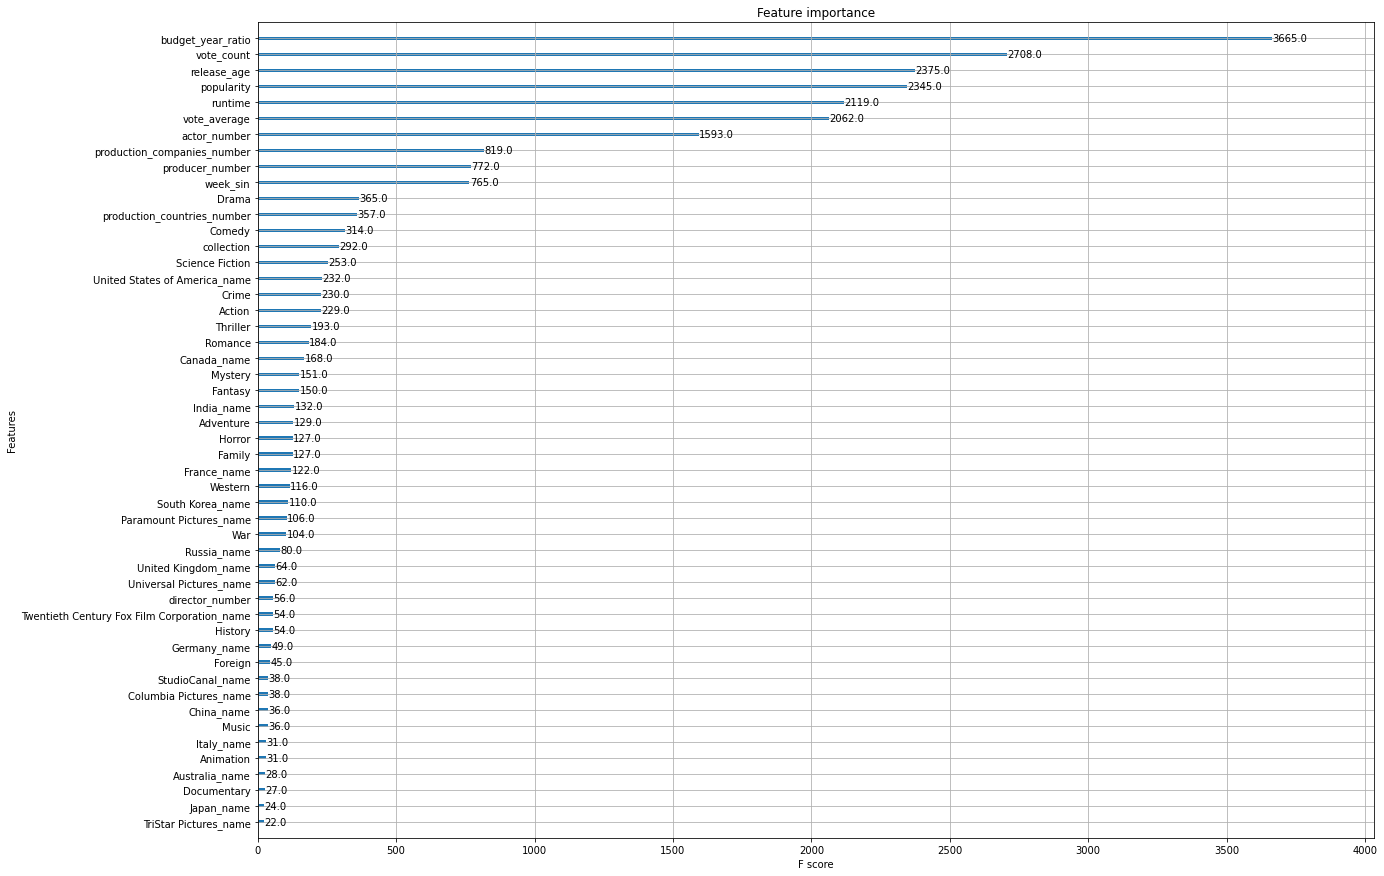

In [59]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(20, 15))
xgb.plot_importance(clf_xgb, max_num_features=50, importance_type='weight', ax=ax);

## Predictions

In [ ]:
# # Create dataframe with predicted values
# comp_df = pd.DataFrame(np.expm1(), columns=['predictions'])

# # Add actual values to dataframe
# comp_df['actual'] = np.expm1(scaler_revenue.inverse_transform(y_cross))

# # Add column with difference of the two values
# comp_df['difference'] = comp_df['predictions'] - comp_df['actual']

# # Add column that shows the percent difference between predicted and actual value
# comp_df['percent_diff'] = abs(abs(comp_df['predictions'] / (comp_df['actual'])) - 1) * 100

# # Add column that designates a difference of less than 20% as 'okay' and 20% or more as 'bad'
# comp_df['okay'] = comp_df['percent_diff'].apply(lambda x: 'okay' if x < 20 else 'bad')
# comp_df

In [ ]:
# # Which movies had a difference of less than 20% in the predicted vs. the actual revenue value 
# comp_df[comp_df['okay'] == 'okay'].sort_values('percent_diff')

## PCA

In [60]:
pca = PCA(n_components=20)
pca_X_train = pca.fit_transform(X_train_processed_part)
pca_X_test = pca.transform(X_test_processed)
pca.explained_variance_ratio_

array([9.99989131e-01, 2.08780591e-06, 1.65686761e-06, 1.17205002e-06,
       9.42322754e-07, 6.93951637e-07, 5.86495352e-07, 5.25734822e-07,
       4.50887285e-07, 2.69243310e-07, 2.27893385e-07, 2.04244812e-07,
       1.56164343e-07, 1.39460697e-07, 1.26885500e-07, 1.08957638e-07,
       1.05259226e-07, 1.01733373e-07, 8.57188177e-08, 7.67459243e-08])